In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

import netCDF4 as nc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
import arrow
import warnings
warnings.filterwarnings('ignore')

In [3]:
## retrieve days as arrow objects

start ='2015-01-01'
end ='2015-12-31'

start_run = arrow.get(start)
end_run = arrow.get(end)

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)

In [4]:
#retreive present day DIC and salinity
presday_DIC = np.zeros([365,40,950])
presday_TA = np.zeros([365,40,950])
presday_sal = np.zeros([365,40,950])

for i in range(0,365):

    tdate = arrow_array[i][0]
    #ymd = tdate.format('YYYY')
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}.nc'

#     if i%60 == 0:
#         #print(ymd)
    presday = nc.Dataset(f'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_{ymd}')
    presday_DIC[i,:,:] = presday['DIC'][0,:,0,:]
    presday_TA[i,:,:] = presday['TA'][0,:,0,:]
    presday_sal[i,:,:] = presday['vosaline'][0,:,0,:]
    presday.close()



In [5]:
oldPI_DIC = np.zeros([365,40,950])
for i in range(0,365):

    tdate = arrow_array[i][0]
    #ymd = tdate.format('YYYY')
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}.nc'

    #if i%60 == 0:
        #print(ymd)
    oldPI = nc.Dataset(f'./PREIND_BCCOND/PREIND_BC_v201905_{ymd}')
    oldPI_DIC[i,:,:] = oldPI['DIC'][0,:,0,:]      
    oldPI.close()



In [8]:
#LO_AOUmethod_stoicCO_diseq_allup_y2015m12d29_preind_DIC.nc

newPI_DIC = np.zeros([365,40,950])
# newPI_sigma0 = np.zeros([365,40,950])
for i in range(0,365):

    tdate = arrow_array[i][0]
    yy = tdate.format('YYYY')
    mm = tdate.format('MM')
    dd = tdate.format('DD')
    ymd = f'y{yy}m{mm}d{dd}'

    newPI = nc.Dataset(f'./PREIND_BCCOND/PI_AOU_SIGADJ_v201905_{ymd}.nc')
    newPI_DIC[i,:,:] = newPI['DIC'][0,:,0,:]      

    newPI.close()

In [10]:
## averages

newPI_DIC_monthly = np.zeros([12,40,950])
newPI_DIC_sigadj_monthly = np.zeros([12,40,950])
oldPI_DIC_monthly = np.zeros([12,40,950])
presday_DIC_monthly = np.zeros([12,40,950])
presday_TA_monthly = np.zeros([12,40,950])
newPI_sigma0_monthly = np.zeros([12,40,950])


for i in range(0,12):
    
    newPI_DIC_monthly[i,:,:] = \
        np.nanmean(newPI_DIC[(i*30):((i+1)*30),:,:], axis = 0)
    oldPI_DIC_monthly[i,:,:] = \
        np.nanmean(oldPI_DIC[(i*30):((i+1)*30),:,:], axis = 0)
    presday_DIC_monthly[i,:,:] = \
        np.nanmean(presday_DIC[(i*30):((i+1)*30),:,:], axis = 0)
    presday_TA_monthly[i,:,:] = \
        np.nanmean(presday_TA[(i*30):((i+1)*30),:,:], axis = 0)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


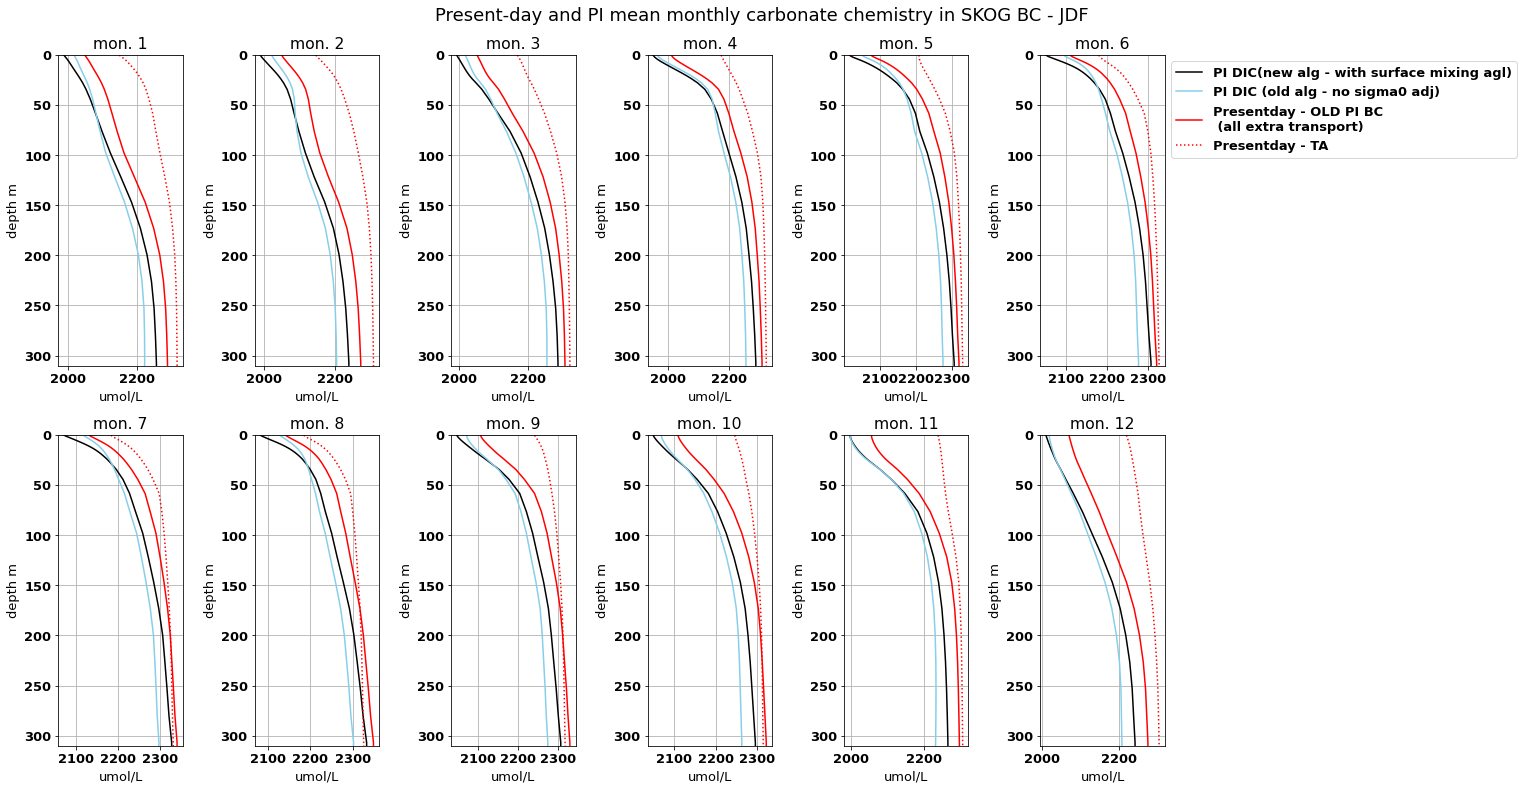

In [12]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 13}

plt.rc('font', **font)


w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

depths = w['gdept_1d'][0,:]

fact = 0.8
fig, axs = plt.subplots(2,6, figsize=(26.7*fact, 14*fact), facecolor='w', edgecolor='k')
#plt.xticks(rotation=70)

axs = axs.ravel()

for i in range(0,12):

    axs[i].plot(np.nanmean(newPI_DIC_monthly[i,:,:],axis = 1), \
                depths, color = 'k', \
                linestyle = '-', label = 'PI DIC(new alg - with surface mixing agl)')
    axs[i].plot(np.nanmean(oldPI_DIC_monthly[i,:,:],axis = 1), \
                depths, color = 'skyblue', \
                linestyle = '-', label = 'PI DIC (old alg - no sigma0 adj)')        
#     axs[i].plot(np.nanmean(newPI_DIC_sigadj_monthly[i,:,:],axis = 1), \
#                 depths, color = 'b', \
#                 linestyle = '-', label = 'PI DIC (new alg - with sigma0 adj)')
    axs[i].plot(np.nanmean(presday_DIC_monthly[i,:,:],axis = 1), \
                depths, color = 'r', \
                linestyle = '-', label = 'Presentday - OLD PI BC \n (all extra transport)')
    axs[i].plot(np.nanmean(presday_TA_monthly[i,:,:],axis = 1), \
                depths, color = 'r', \
                linestyle = ':', label = 'Presentday - TA')
   # plt.xticks(rotation=70) 
for i in range(0,12):
    axs[i].grid();
    axs[i].set_ylim([0,310])
    axs[i].invert_yaxis()
    axs[i].set_title(f'mon. {i+1}')
    axs[i].set_ylabel('depth m')
    axs[i].set_xlabel('umol/L')

    
axs[5].legend(bbox_to_anchor = [1, 1])    
plt.suptitle('Present-day and PI mean monthly carbonate chemistry in SKOG BC - JDF', fontsize = 18)
plt.tight_layout()

In [16]:
JS_presday = nc.Dataset('/data/tjarniko/MEOPAR/tracers/north/Dosser_north_TEOS10_DICTA.nc')
JS_PIold = nc.Dataset('/data/tjarniko/MEOPAR/tracers/north/Dosser_north_TEOS10_DICTA_preind_091719.nc')
JS_PInew = nc.Dataset('/data/tjarniko/MEOPAR/tracers/north/Dosser_north_TEOS10_DICTA_PIDIC_from_sal_rel.nc')

JS_PIold_DIC = JS_PIold['DIC'][:]
JS_PInew_DIC = JS_PInew['DIC'][:]
JS_presday_DIC = JS_presday['DIC'][:]
JS_presday_TA = JS_presday['TA'][:]
JS_PInew_TA = JS_PInew['TA'][:]

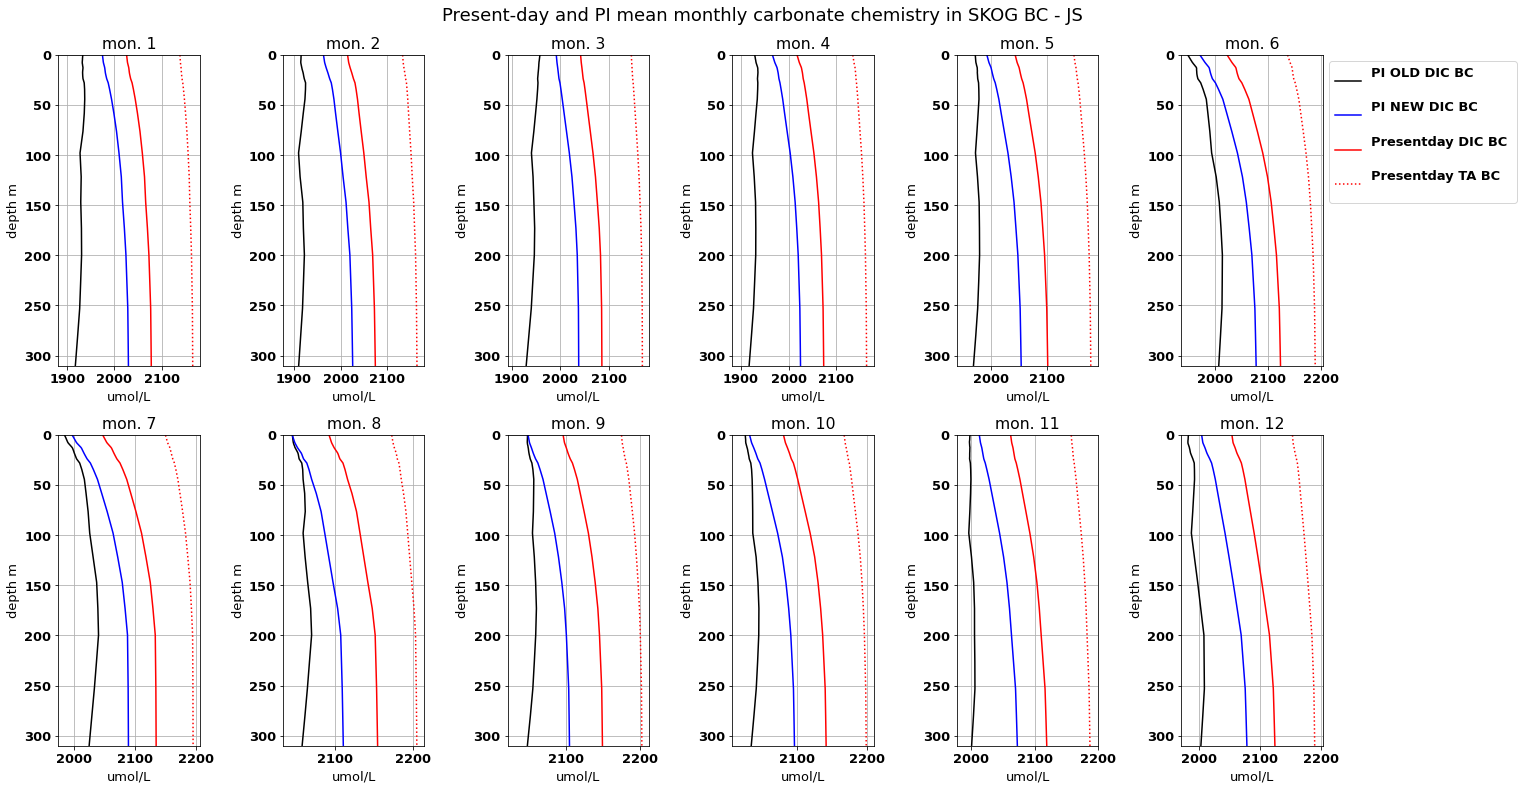

In [23]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 13}

plt.rc('font', **font)


w = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

depths = w['gdept_1d'][0,:]

fact = 0.8
fig, axs = plt.subplots(2,6, figsize=(26.7*fact, 14*fact), facecolor='w', edgecolor='k')
#plt.xticks(rotation=70)

axs = axs.ravel()

for i in range(0,12):

    axs[i].plot(np.nanmean(np.nanmean(JS_PIold_DIC[i,:,:,:],axis = 1),axis=1), \
                depths, color = 'k', \
                linestyle = '-', label = 'PI OLD DIC BC \n')

    axs[i].plot(np.nanmean(np.nanmean(JS_PInew_DIC[i,:,:,:],axis = 1),axis=1), \
                depths, color = 'b', \
                linestyle = '-', label = 'PI NEW DIC BC \n')
    
    axs[i].plot(np.nanmean(np.nanmean(JS_presday_DIC[i,:,:,:],axis = 1),axis=1), \
                depths, color = 'r', \
                linestyle = '-', label = 'Presentday DIC BC \n')

    axs[i].plot(np.nanmean(np.nanmean(JS_presday_TA[i,:,:,:],axis = 1),axis=1), \
                depths, color = 'r', \
                linestyle = ':', label = 'Presentday TA BC \n')

for i in range(0,12):
    axs[i].grid();
    axs[i].set_ylim([0,310])
    axs[i].invert_yaxis()
    axs[i].set_title(f'mon. {i+1}')
    axs[i].set_ylabel('depth m')
    axs[i].set_xlabel('umol/L')

    
axs[5].legend(bbox_to_anchor = [1, 1])    
plt.suptitle('Present-day and PI mean monthly carbonate chemistry in SKOG BC - JS', fontsize = 18)
plt.tight_layout()

In [18]:
print(np.shape(np.nanmean(JS_presday_DIC[i,:,:,:],axis = 1)))

(40, 30)
